In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/workspaces/codespaces-jupyter/data/final_cleaned_taxi_data.csv')

data.drop(columns=['trip_end_timestamp'],inplace= True)


In [3]:
data.columns

Index(['trip_start_timestamp', 'trip_duration_seconds', 'trip_distance_miles',
       'pickup_community_area', 'dropoff_community_area', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

In [2]:
data.shape

(4901005, 9)

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_dataset(df):
    """
    Prepares the dataset by extracting temporal features and dropping unnecessary columns.

    Parameters:
    - df: The original DataFrame containing the dataset.

    Returns:
    - A DataFrame with the prepared dataset.
    """
    # Convert trip_start_timestamp and trip_end_timestamp to datetime
    df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])

    # Extract hour of the day (cosine and sine)
    df['hour_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.hour / 24)
    df['hour_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.hour / 24)

    # Extract day of the week (cosine and sine)
    df['day_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.dayofweek / 6)
    df['day_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.dayofweek / 6)

    
    # Extract quarter of the hour (cosine and sine)
    df['quarter_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.minute / 15)
    df['quarter_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.minute / 15)
    # Extract is weekend
    df['is_weekend'] = df['trip_start_timestamp'].dt.dayofweek >= 5
    df['is_weekend'] = df['is_weekend'].astype(int)  # Convert to 0 or 1

    # Extract is morning rush hour (6-9 AM)
    df['is_morning_rush'] = (df['trip_start_timestamp'].dt.hour >= 6) & (df['trip_start_timestamp'].dt.hour < 9)
    df['is_morning_rush'] = df['is_morning_rush'].astype(int)  # Convert to 0 or 1

    # Extract is evening rush hour (4-7 PM)
    df['is_evening_rush'] = (df['trip_start_timestamp'].dt.hour >= 16) & (df['trip_start_timestamp'].dt.hour < 19)
    df['is_evening_rush'] = df['is_evening_rush'].astype(int)  # Convert to 0 or 1
    # Drop unnecessary columns
    df.drop([ 'trip_start_timestamp','pickup_community_area', 'dropoff_community_area'], axis=1, inplace=True)

    return df



In [3]:
prepared_df = prepare_dataset(data)

## Model

**One-Hot Encoding**
One-hot encoding is a process where each category in a categorical variable is converted into a new binary column (0 or 1). This method is straightforward and works well with models that can handle binary features, like XGBoost. However, it can lead to a high-dimensional dataset if the categorical variable has many unique values, for now we only selected 5 community areas.

In [5]:
prepared_df.columns

Index(['trip_duration_seconds', 'trip_distance_miles', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'hour_cos',
       'hour_sin', 'day_cos', 'day_sin', 'quarter_cos', 'quarter_sin',
       'is_weekend', 'is_morning_rush', 'is_evening_rush'],
      dtype='object')

In [4]:
prepared_df.drop(columns=["trip_duration_seconds"], inplace=True)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Prepare feature matrix X and target vector y
X = prepared_df.drop('trip_distance_miles', axis=1)
y = prepared_df['trip_distance_miles']

# Define the cut-off point for 80% of the dataset (change the proportion as needed)
cutoff = int(len(prepared_df) * 0.8)

# Split data into train and test sets based on the time sequence
X_train, X_test = X.iloc[:cutoff], X.iloc[cutoff:]
y_train, y_test = y.iloc[:cutoff], y.iloc[cutoff:]

In [9]:
from sklearn.preprocessing import StandardScaler


# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### Train the Model: Now, train your model using the normalized training data.

## Predict trip duration without the distance feature

In [22]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 7,
    'alpha': 10,
    'learning_rate': 0.02,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_lambda': 1,
    'eval_metric': 'rmse'
}

num_rounds = 700
early_stopping_rounds = 10

bst = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'test')], early_stopping_rounds=early_stopping_rounds, verbose_eval=10)


[0]	test-rmse:1076.70517


/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:34:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	test-rmse:916.97567
[20]	test-rmse:814.36425
[30]	test-rmse:720.37782
[40]	test-rmse:635.82675
[50]	test-rmse:568.93462
[60]	test-rmse:521.84914
[70]	test-rmse:479.63772
[80]	test-rmse:448.01387
[90]	test-rmse:423.60590
[100]	test-rmse:406.42148
[110]	test-rmse:394.42998
[120]	test-rmse:384.40870
[130]	test-rmse:377.34422
[140]	test-rmse:372.86269
[150]	test-rmse:368.63350
[160]	test-rmse:365.83131
[170]	test-rmse:363.49626
[180]	test-rmse:361.66030
[190]	test-rmse:360.27188
[200]	test-rmse:358.87950
[210]	test-rmse:357.74658
[220]	test-rmse:356.98911
[230]	test-rmse:356.38032
[240]	test-rmse:355.71423
[250]	test-rmse:355.33874
[260]	test-rmse:354.93347
[270]	test-rmse:354.60063
[280]	test-rmse:354.31909
[290]	test-rmse:353.89948
[300]	test-rmse:353.51216
[310]	test-rmse:353.20933
[320]	test-rmse:352.93955
[330]	test-rmse:352.71410
[340]	test-rmse:352.46715
[350]	test-rmse:352.28441
[360]	test-rmse:352.08448
[370]	test-rmse:351.95857
[380]	test-rmse:351.78279
[390]	test-rmse:351.6

In [25]:
joblib.dump(bst, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = bst.predict(dtest)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


Mean Squared Error: 122168.8984375
Root Mean Squared Error: 349.5266777193123
R-squared: 0.8981631483291775


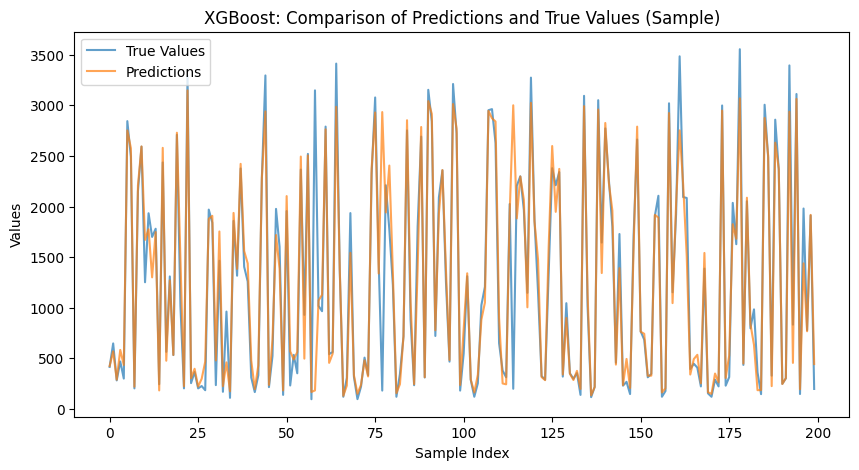

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test set
y_pred = bst.predict(dtest)

# Assuming the true values are stored in a DataFrame
# Replace y_test with your actual true values
y_test = dtest.get_label()

# Define the sample size
sample_size = 200  # Adjust the sample size as needed

# Randomly select a subset of indices
sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)

# Alternatively, you can select a sequential subset
# sample_indices = np.arange(sample_size)

# Get the sampled true values and predictions
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y_test_sample, label='True Values', alpha=0.7)
plt.plot(y_pred_sample, label='Predictions', alpha=0.7)
plt.title('XGBoost: Comparison of Predictions and True Values (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()


__________________

## Predict trip  distance without the  duration feature

In [7]:
prepared_df.columns

Index(['trip_duration_seconds', 'trip_distance_miles', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'hour_cos',
       'hour_sin', 'day_cos', 'day_sin', 'quarter_cos', 'quarter_sin',
       'is_weekend', 'is_morning_rush', 'is_evening_rush'],
      dtype='object')

In [8]:
prepared_df.drop(columns=['trip_duration_seconds'], inplace= True)

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Prepare feature matrix X and target vector y
X = prepared_df.drop('trip_distance_miles', axis=1)
y = prepared_df['trip_distance_miles']

# Define the cut-off points for 70% train, 20% validation, and 10% test (change the proportions as needed)
train_cutoff = int(len(prepared_df) * 0.7)
val_cutoff = int(len(prepared_df) * 0.9)

# Split data into train, validation, and test sets based on the time sequence
X_train, X_val, X_test = X.iloc[:train_cutoff], X.iloc[train_cutoff:val_cutoff], X.iloc[val_cutoff:]
y_train, y_val, y_test = y.iloc[:train_cutoff], y.iloc[train_cutoff:val_cutoff], y.iloc[val_cutoff:]

# Convert the datasets into DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'eval_metric': 'rmse'
}

# Train the model, specifying the validation set
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=50)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")




[0]	train-rmse:5.54173	eval-rmse:5.78181
[1]	train-rmse:5.09453	eval-rmse:5.31296
[2]	train-rmse:4.69956	eval-rmse:4.89769
[3]	train-rmse:4.35258	eval-rmse:4.53256
[4]	train-rmse:4.04839	eval-rmse:4.21189
[5]	train-rmse:3.78105	eval-rmse:3.92981
[6]	train-rmse:3.55107	eval-rmse:3.68658
[7]	train-rmse:3.34426	eval-rmse:3.46876
[8]	train-rmse:3.16496	eval-rmse:3.27978
[9]	train-rmse:3.01089	eval-rmse:3.11689
[10]	train-rmse:2.87604	eval-rmse:2.97475
[11]	train-rmse:2.76307	eval-rmse:2.85506
[12]	train-rmse:2.66380	eval-rmse:2.75041
[13]	train-rmse:2.57595	eval-rmse:2.65757
[14]	train-rmse:2.50184	eval-rmse:2.57912
[15]	train-rmse:2.43969	eval-rmse:2.51319
[16]	train-rmse:2.38639	eval-rmse:2.45669
[17]	train-rmse:2.34124	eval-rmse:2.40904
[18]	train-rmse:2.30040	eval-rmse:2.36632
[19]	train-rmse:2.26642	eval-rmse:2.33083
[20]	train-rmse:2.23851	eval-rmse:2.30144
[21]	train-rmse:2.21446	eval-rmse:2.27614
[22]	train-rmse:2.19153	eval-rmse:2.25244
[23]	train-rmse:2.17234	eval-rmse:2.23257
[2

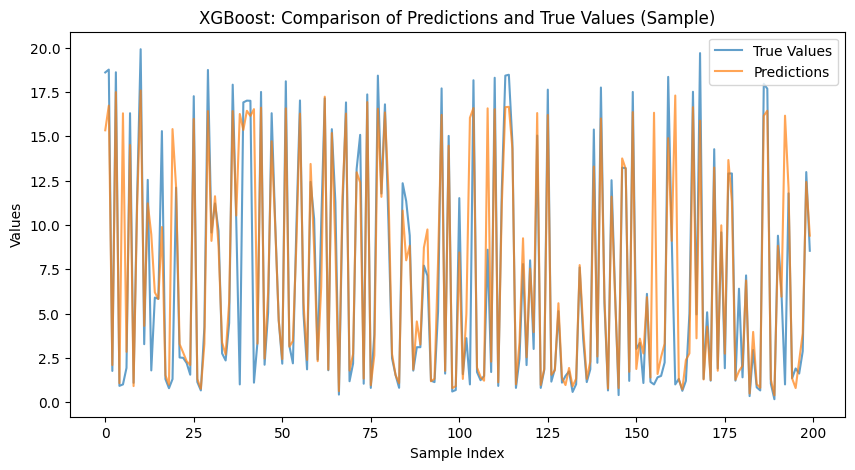

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test set
y_pred = model.predict(dtest)

# Assuming the true values are stored in a DataFrame
# Replace y_test with your actual true values
y_test = dtest.get_label()

# Define the sample size
sample_size = 200  # Adjust the sample size as needed

# Randomly select a subset of indices
sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)

# Alternatively, you can select a sequential subset
# sample_indices = np.arange(sample_size)

# Get the sampled true values and predictions
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y_test_sample, label='True Values', alpha=0.7)
plt.plot(y_pred_sample, label='Predictions', alpha=0.7)
plt.title('XGBoost: Comparison of Predictions and True Values (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = model.predict(dtest)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


Mean Squared Error: 3.3264834880828857
Root Mean Squared Error: 1.8238649862538854
R-squared: 0.9046150723300497


In [14]:
import joblib
joblib.dump(model, 'xgboost_distance_model.pkl')

['xgboost_distance_model.pkl']

___________________________

## Model Inference:  Predict trip  distance for a generated trips sample

In [94]:
import pandas as pd
generated_trips= pd.read_csv('/workspaces/codespaces-jupyter/data/test_xgboost/generated_trips_sample.csv')

In [95]:
generated_trips.shape

(166984, 6)

In [97]:
generated_trips=generated_trips.drop_duplicates()

In [98]:
generated_trips.shape

(20880, 6)

In [99]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_dataset_predict_distance(df):
    """
    Prepares the dataset by extracting temporal features and dropping unnecessary columns.

    Parameters:
    - df: The original DataFrame containing the dataset.

    Returns:
    - A DataFrame with the prepared dataset.
    - A Series with the trip start timestamps.
    """
    # Convert trip_start_timestamp to datetime
    df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])

    # Keep the trip_start_timestamp in a separate variable
    trip_start_timestamps = df['trip_start_timestamp']

    # Extract hour of the day (cosine and sine)
    df['hour_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.hour / 24)
    df['hour_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.hour / 24)

    # Extract day of the week (cosine and sine)
    df['day_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.dayofweek / 6)
    df['day_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.dayofweek / 6)

    # Extract quarter of the hour (cosine and sine)
    df['quarter_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.minute / 15)
    df['quarter_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.minute / 15)

    # Extract is weekend
    df['is_weekend'] = df['trip_start_timestamp'].dt.dayofweek >= 5
    df['is_weekend'] = df['is_weekend'].astype(int)  # Convert to 0 or 1

    # Extract is morning rush hour (6-9 AM)
    df['is_morning_rush'] = (df['trip_start_timestamp'].dt.hour >= 6) & (df['trip_start_timestamp'].dt.hour < 9)
    df['is_morning_rush'] = df['is_morning_rush'].astype(int)  # Convert to 0 or 1

    # Extract is evening rush hour (4-7 PM)
    df['is_evening_rush'] = (df['trip_start_timestamp'].dt.hour >= 16) & (df['trip_start_timestamp'].dt.hour < 19)
    df['is_evening_rush'] = df['is_evening_rush'].astype(int)  # Convert to 0 or 1

    # Drop unnecessary columns
    df.drop(['trip_start_timestamp'], axis=1, inplace=True)

    return df, trip_start_timestamps

# Example usage
# Assuming 'agregated_data' is your original DataFrame
prepared_df, trip_start_timestamps = prepare_dataset(generated_trips)


In [100]:
trip_start_timestamps.shape

(20880,)

In [101]:
prepared_df.shape

(20880, 14)

In [102]:
prepared_df.columns

Index(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'trip_distance_miles', 'hour_cos', 'hour_sin',
       'day_cos', 'day_sin', 'quarter_cos', 'quarter_sin', 'is_weekend',
       'is_morning_rush', 'is_evening_rush'],
      dtype='object')

In [103]:
import xgboost as xgb
import pandas as pd
import joblib
# Assume 'generated_test' is your new dataframe that you want to perform inference on
# Ensure that 'generated_test' is preprocessed in the same way as the training data

# Drop the target column if it exists, since we're doing inference
if 'trip_distance_miles' in prepared_df.columns:
    X_generated_test = prepared_df.drop('trip_distance_miles', axis=1)
else:
    X_generated_test = prepared_df

# Convert the new data into a DMatrix for XGBoost
dgenerated_test = xgb.DMatrix(X_generated_test)

# Load the trained model (assuming you have saved it earlier)
model = xgb.Booster()
# Load the trained model from the .pkl file
model = joblib.load('/workspaces/codespaces-jupyter/notebooks/xgboost_distance_model.pkl')


# Perform inference
y_generated_pred = model.predict(dgenerated_test)

# Add the predictions back to the dataframe (if desired)
prepared_df['predicted_trip_distance_miles'] = y_generated_pred


In [104]:
prepared_df.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,hour_cos,hour_sin,day_cos,day_sin,quarter_cos,quarter_sin,is_weekend,is_morning_rush,is_evening_rush,predicted_trip_distance_miles
0,41.93476,-87.639854,41.900223,-87.629105,2.936951,-0.5,0.866025,0.5,-0.866025,1.0,0.0,1,1,0,3.042091
1,41.93476,-87.639854,41.911972,-87.683640,3.301227,-0.5,0.866025,0.5,-0.866025,1.0,0.0,1,1,0,3.759552
2,41.93476,-87.639854,41.878864,-87.625190,4.717405,-0.5,0.866025,0.5,-0.866025,1.0,0.0,1,1,0,4.643526
3,41.93476,-87.639854,41.929047,-87.651310,0.852113,-0.5,0.866025,0.5,-0.866025,1.0,0.0,1,1,0,2.300505
4,41.93476,-87.639854,41.899590,-87.674720,3.624476,-0.5,0.866025,0.5,-0.866025,1.0,0.0,1,1,0,4.099584


In [105]:
# Merge the original timestamps back into the DataFrame
prepared_df['trip_start_timestamp'] = trip_start_timestamps.values


In [107]:
prepared_df.drop(columns=['trip_distance_miles', 'hour_cos', 'hour_sin',
       'day_cos', 'day_sin', 'quarter_cos', 'quarter_sin', 'is_weekend',
       'is_morning_rush', 'is_evening_rush'], inplace=True)

In [108]:
prepared_df.rename(columns={'predicted_trip_distance_miles': 'trip_distance_miles'}, inplace=True)

In [109]:
prepared_df.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,trip_start_timestamp
0,41.93476,-87.639854,41.900223,-87.629105,3.042091,2023-12-02 08:00:00
1,41.93476,-87.639854,41.911972,-87.683640,3.759552,2023-12-02 08:00:00
2,41.93476,-87.639854,41.878864,-87.625190,4.643526,2023-12-02 08:00:00
3,41.93476,-87.639854,41.929047,-87.651310,2.300505,2023-12-02 08:00:00
4,41.93476,-87.639854,41.899590,-87.674720,4.099584,2023-12-02 08:00:00


In [110]:
prepared_df.shape

(20880, 6)

In [111]:
import pandas as pd

# Example dataframe, assuming 'generated_test' is already loaded

# Define the filter values
pickup_lat = 41.863422
pickup_long = -87.653755
dropoff_lat = 41.870415
dropoff_long = -87.67509

# Apply the filter
filtered_df = prepared_df[
    (prepared_df['pickup_latitude'] == pickup_lat) &
    (prepared_df['pickup_longitude'] == pickup_long) &
    (prepared_df['dropoff_latitude'] == dropoff_lat) &
    (prepared_df['dropoff_longitude'] == dropoff_long)
]

# Display the filtered dataframe
filtered_df


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,trip_start_timestamp
6159,41.863422,-87.653755,41.870415,-87.67509,3.200388,2023-12-02 08:00:00
13119,41.863422,-87.653755,41.870415,-87.67509,3.174039,2023-12-02 08:15:00
20079,41.863422,-87.653755,41.870415,-87.67509,3.167853,2023-12-02 08:30:00
27039,41.863422,-87.653755,41.870415,-87.67509,3.175905,2023-12-02 08:45:00
33999,41.863422,-87.653755,41.870415,-87.67509,3.256637,2023-12-02 09:00:00
40959,41.863422,-87.653755,41.870415,-87.67509,3.240676,2023-12-02 09:15:00
47919,41.863422,-87.653755,41.870415,-87.67509,3.235373,2023-12-02 09:30:00
54879,41.863422,-87.653755,41.870415,-87.67509,3.239935,2023-12-02 09:45:00
61839,41.863422,-87.653755,41.870415,-87.67509,3.269857,2023-12-02 10:00:00
68799,41.863422,-87.653755,41.870415,-87.67509,3.246148,2023-12-02 10:15:00


In [112]:
filtered_df.columns

Index(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'trip_distance_miles', 'trip_start_timestamp'],
      dtype='object')

In [114]:
# Reorder the columns so that trip_start_timestamp is the first column
columns_order = ['trip_start_timestamp', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'trip_distance_miles']
df = prepared_df[columns_order]

# Reset the index
df.reset_index(drop=True, inplace=True)

In [115]:
df.head()

,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles
0,2023-12-02 08:00:00,41.93476,-87.639854,41.900223,-87.629105,3.042091
1,2023-12-02 08:00:00,41.93476,-87.639854,41.911972,-87.683640,3.759552
2,2023-12-02 08:00:00,41.93476,-87.639854,41.878864,-87.625190,4.643526
3,2023-12-02 08:00:00,41.93476,-87.639854,41.929047,-87.651310,2.300505
4,2023-12-02 08:00:00,41.93476,-87.639854,41.899590,-87.674720,4.099584


In [116]:
df.to_csv('/workspaces/codespaces-jupyter/data/test_xgboost/predicted_distance__generated_trips.csv')

______________________

## Model inference: Predict trip  duration  for the generated trips

In [35]:
import pandas as pd
generated_trips=pd.read_csv('/workspaces/codespaces-jupyter/data/test_xgboost/generated_trips_sample.csv')

In [36]:
generated_trips=generated_trips.drop_duplicates()

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_dataset(df):
    """
    Prepares the dataset by extracting temporal features and dropping unnecessary columns.

    Parameters:
    - df: The original DataFrame containing the dataset.

    Returns:
    - A DataFrame with the prepared dataset.
    """
    # Convert trip_start_timestamp and trip_end_timestamp to datetime
    df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
    # Keep the trip_start_timestamp in a separate variable
    trip_start_timestamps = df['trip_start_timestamp']
    # Extract hour of the day as a number
    df['hour'] = df['trip_start_timestamp'].dt.hour

    # Extract day of the week as a number
    df['day_of_week'] = df['trip_start_timestamp'].dt.dayofweek

    # Extract quarter of the hour as a number
    df['quarter'] = df['trip_start_timestamp'].dt.minute // 15

    # Extract is weekend
    df['is_weekend'] = df['trip_start_timestamp'].dt.dayofweek >= 5
    df['is_weekend'] = df['is_weekend'].astype(int)  # Convert to 0 or 1

    # Extract is morning rush hour (6-9 AM)
    df['is_morning_rush'] = (df['trip_start_timestamp'].dt.hour >= 6) & (df['trip_start_timestamp'].dt.hour < 9)
    df['is_morning_rush'] = df['is_morning_rush'].astype(int)  # Convert to 0 or 1

    # Extract is evening rush hour (4-7 PM)
    df['is_evening_rush'] = (df['trip_start_timestamp'].dt.hour >= 16) & (df['trip_start_timestamp'].dt.hour < 19)
    df['is_evening_rush'] = df['is_evening_rush'].astype(int)  # Convert to 0 or 1

    # Drop unnecessary columns
    df.drop(['trip_start_timestamp'], axis=1, inplace=True)

    return df, trip_start_timestamps



In [38]:
# Assuming 'agregated_data' is your original DataFrame
prepared_df, trip_start_timestamps = prepare_dataset(generated_trips)

In [39]:
prepared_df.shape

(20880, 11)

In [30]:
prepared_df.columns

Index(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'trip_distance_miles', 'hour', 'day_of_week',
       'quarter', 'is_weekend', 'is_morning_rush', 'is_evening_rush'],
      dtype='object')

In [40]:
import xgboost as xgb
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the generated test data
# Assume 'generated_test' is your new dataframe that you want to perform inference on

# Load the feature scalers (preprocessor)
preprocessor = joblib.load('/workspaces/codespaces-jupyter/data/test_xgboost/xgb_travel_time/feature_scaler_tt.pkl')

# Apply the preprocessing to the new data
X_generated_test_transformed = preprocessor.transform(prepared_df)

# Convert the new data into a DMatrix for XGBoost
dgenerated_test = xgb.DMatrix(X_generated_test_transformed)

# Load the trained model from the .pkl file using joblib
model = joblib.load('/workspaces/codespaces-jupyter/data/test_xgboost/xgb_travel_time/xgboost_tt.pkl')

# Perform inference
y_generated_pred = model.predict(dgenerated_test)



In [41]:
# Add the predictions back to the dataframe
prepared_df['predicted_trip_duration_seconds'] = y_generated_pred


In [42]:
prepared_df.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,hour,day_of_week,quarter,is_weekend,is_morning_rush,is_evening_rush,predicted_trip_duration_seconds
0,41.93476,-87.639854,41.900223,-87.629105,2.936951,8,5,0,1,1,0,546.998047
1,41.93476,-87.639854,41.911972,-87.683640,3.301227,8,5,0,1,1,0,616.023071
2,41.93476,-87.639854,41.878864,-87.625190,4.717405,8,5,0,1,1,0,856.016479
3,41.93476,-87.639854,41.929047,-87.651310,0.852113,8,5,0,1,1,0,201.610611
4,41.93476,-87.639854,41.899590,-87.674720,3.624476,8,5,0,1,1,0,670.116394


In [43]:
# Merge the original timestamps back into the DataFrame
prepared_df['trip_start_timestamp'] = trip_start_timestamps.values


In [44]:
prepared_df.columns

Index(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'trip_distance_miles', 'hour', 'day_of_week',
       'quarter', 'is_weekend', 'is_morning_rush', 'is_evening_rush',
       'predicted_trip_duration_seconds', 'trip_start_timestamp'],
      dtype='object')

In [45]:
prepared_df.drop(columns=['hour', 'day_of_week',
       'quarter', 'is_weekend', 'is_morning_rush', 'is_evening_rush'], inplace=True)
prepared_df.rename(columns={'predicted_trip_distance_miles': 'trip_distance_miles'}, inplace=True)

In [46]:
import pandas as pd

# Example dataframe, assuming 'generated_test' is already loaded

# Define the filter values
pickup_lat = 41.863422
pickup_long = -87.653755
dropoff_lat = 41.870415
dropoff_long = -87.67509

# Apply the filter
filtered_df = prepared_df[
    (prepared_df['pickup_latitude'] == pickup_lat) &
    (prepared_df['pickup_longitude'] == pickup_long) &
    (prepared_df['dropoff_latitude'] == dropoff_lat) &
    (prepared_df['dropoff_longitude'] == dropoff_long)
]

# Display the filtered dataframe
filtered_df


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,predicted_trip_duration_seconds,trip_start_timestamp
6159,41.863422,-87.653755,41.870415,-87.67509,1.441799,267.211029,2023-12-02 08:00:00
13119,41.863422,-87.653755,41.870415,-87.67509,1.441799,267.211029,2023-12-02 08:15:00
20079,41.863422,-87.653755,41.870415,-87.67509,1.441799,267.211029,2023-12-02 08:30:00
27039,41.863422,-87.653755,41.870415,-87.67509,1.441799,267.211029,2023-12-02 08:45:00
33999,41.863422,-87.653755,41.870415,-87.67509,1.441799,262.489044,2023-12-02 09:00:00
40959,41.863422,-87.653755,41.870415,-87.67509,1.441799,262.489044,2023-12-02 09:15:00
47919,41.863422,-87.653755,41.870415,-87.67509,1.441799,262.489044,2023-12-02 09:30:00
54879,41.863422,-87.653755,41.870415,-87.67509,1.441799,262.489044,2023-12-02 09:45:00
61839,41.863422,-87.653755,41.870415,-87.67509,1.441799,262.489044,2023-12-02 10:00:00
68799,41.863422,-87.653755,41.870415,-87.67509,1.441799,262.489044,2023-12-02 10:15:00
